# 1. Requirements and setup

We need to run this script with GPU, otherwise, some steps will be too slow.

In [4]:
# Perform Google Colab installs (if running in Google Colab)

print("[INFO] Running in Google Colab, installing requirements.")
!pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
!pip install PyMuPDF # for reading PDFs with Python
!pip install tqdm # for progress bars
!pip install torchvision
!pip install sentence-transformers # for embedding models
!pip install accelerate # for quantization model loading
!pip install bitsandbytes # for quantizing models (less storage space)
!pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.
  Using cached torch-2.4.0-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached triton-3.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.3 kB)
Using cached torch-2.4.0-cp310-cp310-manylinux1_x86_64.whl (797.2 MB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached triton-3.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (209.4 MB)
  Attempting uninstall: triton
    Found existing installation: triton 2.3.1
    Uninstalling triton-2.3.1:
      Successfully uninstalled triton-2.3.1
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 8.9.2.26
    Uninstalling nvidia-cudnn-cu12-8.9.2.26:
      Successfully uninstalled nvidia-cudnn-cu12-8.9.2.26
  Attempting uninstall: torch
    Found existing insta

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
cur_path = '/content/drive/MyDrive/claudiaYao - Colab Notebooks/PDF_SUMMARY'

pdf_path = cur_path + "/pdf"
data_path = cur_path + "/data"
output_path = cur_path + "/output"

if not os.path.exists(data_path):
    os.mkdir(data_path)

# 2. Processing the MD files
 - Keep some meta data for each page's md info.
 - Split sentences
 - Chunk into small batches of sentence blocks

### The MD files have been generated in previous steps. Now we need to save each page's MD file to a dictionary and then append that dictionary to a list for ease of use later.

In [7]:
# Requires !pip install PyMuPDF, see: https://github.com/pymupdf/pymupdf
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

# Note: this only focuses on text, rather than images/figures etc
def open_and_read_md(output_path: str, total_page_number) -> list[dict]:
    """
    Opens each MD file, reads its text content page by page, and collects statistics.
    """
    pages_and_texts = []
    for page_number in tqdm(range(total_page_number)):  # iterate the document pages
        with open(output_path + "/" + str(page_number) + "/output-md/output.md", "r") as newfile:
            text = newfile.read()

        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_md(output_path, 6)
pages_and_texts[:2]

  0%|          | 0/6 [00:00<?, ?it/s]

[{'page_number': 0,
  'page_char_count': 5660,
  'page_word_count': 853,
  'page_sentence_count_raw': 49,
  'page_token_count': 1415.0,
  'text': "## Interest Point Detection based on Adaptive Ternary Coding  ## Zhenwei Miao, Membe, IEEE, Kim-Hui Yap, Senior Member, IEEE and Xudong Jiang, Senior Member, IEEE  Abtraci-In this paper, an adaptive pixel ternary coding mechanism is proposed and a contrast invariant and noise resistant interest paint detector is developed on the basis od this mechanism. Every pixel in a local region is adaptively encoded into one of the three statuses: bright, uncertain and dark. The hlob significance of the local region is measured by the spatial distribution of the bright and dark pixels. Interest points are extracted froem this blob significance measurement. By labeling the statuses of ternary bright, uncertain, and durk, the propused errors. Moreover, the adaptive strategy for the ternary cording. which reies on two thresholds that automatically coaverge

Now let's get a random sample of the pages.

In [11]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
display(df.head())
print()
display(df.describe().round(2))

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,0,5660,853,49,1415.0,## Interest Point Detection based on Adaptive ...
1,1,4426,820,40,1106.5,![](figures/0-0-FIGURE.jpg) Fig. 1. {a) input...
2,2,6196,1128,43,1549.0,center and I(x - m) is the pixel gray value at...
3,3,3806,630,35,951.5,![](figures/0-0-FIGURE.jpg) Fig. 2. Results o...
4,4,6106,1028,273,1526.5,TABLE II ![](figures/0-1-FIGURE.jpg) TABLE W...


,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,6.00,6.00,6.00,6.00,6.00
mean,2.50,4478.83,762.00,79.00,1119.71
std,1.87,2092.16,361.93,95.20,523.04
min,0.00,679.00,113.00,34.00,169.75
25%,1.25,3961.00,677.50,36.25,990.25
50%,2.50,5043.00,836.50,41.50,1260.75
75%,3.75,5994.50,984.25,47.50,1498.62
max,5.00,6196.00,1128.00,273.00,1549.00


## Further text processing (splitting pages into sentences)

1. Split the sentences with simple rules.
2. here needs to solve a problem. When there is formula, starting from `$$` or `\[`, we have to wait for the other `$$` or `\[` to end the formula. That means, the formula has to be put into one sentence.

In [12]:
import re
from spacy.lang.en import English # see https://spacy.io/usage for install instructions

nlp = English()
# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

for item in tqdm(pages_and_texts):
    sents = list(nlp(item["text"]).sents)

    results = []
    prev_sent = ""
    cur_sent = ""
    for sent in sents:
        # print("sent:", sent)
        if prev_sent:
            cur_sent = prev_sent + ". " + str(sent)
        else:
            cur_sent = str(sent)

        all_1 = re.findall(r"\$\$", cur_sent)
        all_2 = re.findall(r"\\\[", cur_sent)
        if (len(all_1) % 2 == 1 or len(all_2) % 2 == 1) or len(str(cur_sent).split()) < 6:
            # combine with the next sentence, so that equation will always be put in one sentence
            prev_sent += str(sent)
        else:
            results.append(str(cur_sent))
            # print("curr:", cur_sent)
            prev_sent = ""


    # Make sure all sentences are strings
    item["sentences"] = results

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])




  0%|          | 0/6 [00:00<?, ?it/s]



Now let's turn out list of dictionaries into a DataFrame and get some stats.

In [13]:
df = pd.DataFrame(pages_and_texts)
display(df.head())
print()
display(df.describe().round(2))

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text,sentences,page_sentence_count_spacy
0,0,5660,853,49,1415.0,## Interest Point Detection based on Adaptive ...,[## Interest Point Detection based on Adaptive...,42
1,1,4426,820,40,1106.5,![](figures/0-0-FIGURE.jpg) Fig. 1. {a) input...,[![](figures/0-0-FIGURE.jpg) Fig.1. {. a) inp...,32
2,2,6196,1128,43,1549.0,center and I(x - m) is the pixel gray value at...,[center and I(x - m) is the pixel gray value a...,31
3,3,3806,630,35,951.5,![](figures/0-0-FIGURE.jpg) Fig. 2. Results o...,[![](figures/0-0-FIGURE.jpg) Fig.2.. Results ...,29
4,4,6106,1028,273,1526.5,TABLE II ![](figures/0-1-FIGURE.jpg) TABLE W...,[TABLE II ![](. figures/0-1-FIGURE.jpg) TABL...,87


,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,6.00,6.00,6.00,6.00,6.00,6.00
mean,2.50,4478.83,762.00,79.00,1119.71,38.17
std,1.87,2092.16,361.93,95.20,523.04,26.39
min,0.00,679.00,113.00,34.00,169.75,8.00
25%,1.25,3961.00,677.50,36.25,990.25,29.50
50%,2.50,5043.00,836.50,41.50,1260.75,31.50
75%,3.75,5994.50,984.25,47.50,1498.62,39.50
max,5.00,6196.00,1128.00,273.00,1549.00,87.00


### Chunking our sentences together

Let's take a step to break down our list of sentences/text into smaller chunks.
As you might've guessed, this process is referred to as **chunking**.


In [15]:
import random

# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
print("Show one sample:")
random.sample(pages_and_texts, k=1)

  0%|          | 0/6 [00:00<?, ?it/s]

Show one sample:


[{'page_number': 0,
  'page_char_count': 5660,
  'page_word_count': 853,
  'page_sentence_count_raw': 49,
  'page_token_count': 1415.0,
  'text': "## Interest Point Detection based on Adaptive Ternary Coding  ## Zhenwei Miao, Membe, IEEE, Kim-Hui Yap, Senior Member, IEEE and Xudong Jiang, Senior Member, IEEE  Abtraci-In this paper, an adaptive pixel ternary coding mechanism is proposed and a contrast invariant and noise resistant interest paint detector is developed on the basis od this mechanism. Every pixel in a local region is adaptively encoded into one of the three statuses: bright, uncertain and dark. The hlob significance of the local region is measured by the spatial distribution of the bright and dark pixels. Interest points are extracted froem this blob significance measurement. By labeling the statuses of ternary bright, uncertain, and durk, the propused errors. Moreover, the adaptive strategy for the ternary cording. which reies on two thresholds that automatically coaverge

In [16]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
display(df.head())
print()
display(df.describe().round(2))

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text,sentences,page_sentence_count_spacy,sentence_chunks,num_chunks
0,0,5660,853,49,1415.0,## Interest Point Detection based on Adaptive ...,[## Interest Point Detection based on Adaptive...,42,[[## Interest Point Detection based on Adaptiv...,5
1,1,4426,820,40,1106.5,![](figures/0-0-FIGURE.jpg) Fig. 1. {a) input...,[![](figures/0-0-FIGURE.jpg) Fig.1. {. a) inp...,32,[[![](figures/0-0-FIGURE.jpg) Fig.1. {. a) in...,4
2,2,6196,1128,43,1549.0,center and I(x - m) is the pixel gray value at...,[center and I(x - m) is the pixel gray value a...,31,[[center and I(x - m) is the pixel gray value ...,4
3,3,3806,630,35,951.5,![](figures/0-0-FIGURE.jpg) Fig. 2. Results o...,[![](figures/0-0-FIGURE.jpg) Fig.2.. Results ...,29,[[![](figures/0-0-FIGURE.jpg) Fig.2.. Results...,3
4,4,6106,1028,273,1526.5,TABLE II ![](figures/0-1-FIGURE.jpg) TABLE W...,[TABLE II ![](. figures/0-1-FIGURE.jpg) TABL...,87,[[TABLE II ![](. figures/0-1-FIGURE.jpg) TAB...,9


,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,6.00,6.00,6.00,6.00,6.00,6.00,6.00
mean,2.50,4478.83,762.00,79.00,1119.71,38.17,4.33
std,1.87,2092.16,361.93,95.20,523.04,26.39,2.66
min,0.00,679.00,113.00,34.00,169.75,8.00,1.00
25%,1.25,3961.00,677.50,36.25,990.25,29.50,3.25
50%,2.50,5043.00,836.50,41.50,1260.75,31.50,4.00
75%,3.75,5994.50,984.25,47.50,1498.62,39.50,4.75
max,5.00,6196.00,1128.00,273.00,1549.00,87.00,9.00


Note how the average number of chunks is around 1.5, this is expected since many of our pages only contain an average of 10 sentences.

# Get meta data for each sentence chunk

We'd like to embed each chunk of sentences into its own numerical representation.

So to keep things clean, let's create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [17]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have? it should be more than page number because each page text will be further split into several blocks
print("Total sentence chunks for the file: ", len(pages_and_chunks))
print("See one sample:")
random.sample(pages_and_chunks, k=1)

  0%|          | 0/6 [00:00<?, ?it/s]

Total sentence chunks for the file:  26
See one sample:


[{'page_number': 1,
  'sentence_chunk': "![](figures/0-0-FIGURE.jpg) Fig.1. {. a) input image.fb) an eslarged image puatch.. For this image paich, (c) shows the puxels dvided by the nmediam and (d) shous the puxels divided by the upper und lawer boumds af the II'M algonthnm. (1) shows the corresponding blab aguticance agaimst the number of nennions. (Best viewed m colarl.. than the pixel intensity value under illumination changes. In view of this, we propose to detect interest points using the brightdark labels of pixels. An issue that needs to be addresed is how to differentiate and label the pixels as bright or dark ones. One way is to dichotomize the pixels into bnght and dark ones by a certain threshod, which could be set by the mean or median value of the local region. Take the image patch (shown in Fig.1(b).. as a zoom in from Fig.l(a)) as an example, the bright and dark pixels dichotomized by the median value are identitied in Fig.",
  'chunk_char_count': 911,
  'chunk_word_coun

In [20]:
df = pd.DataFrame(pages_and_chunks)
display(df.head())
print()
display(df.describe().round(2))

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,0,## Interest Point Detection based on Adaptive ...,1254,186,313.50
1,0,## I. INTRODUC'TION AA well-designed interest ...,1307,192,326.75
2,0,Singapoee.. The ROSE Lab s supporied by the Na...,1613,231,403.25
3,0,Inspired by the recent wrk on the lterative Tr...,1277,198,319.25
4,0,"However, the linear filter based detectors, su...",196,32,49.00


,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,26.00,26.00,26.00,26.00
mean,2.38,1027.27,168.42,256.82
std,1.65,586.92,103.77,146.73
min,0.00,67.00,12.00,16.75
25%,1.00,566.00,86.00,141.50
50%,2.50,1034.50,170.00,258.62
75%,4.00,1409.00,222.75,352.25
max,5.00,2489.00,428.00,622.25


Hmm looks like some of our chunks have quite a low token count.

How about we check for samples with less than 30 tokens (about the length of a sentence) and see if they are worth keeping?

In [22]:
# Show random chunks with under 30 tokens in length
min_token_length = 26
for row in df[df["chunk_token_count"] <= min_token_length].sample(1).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 16.75 | Text: We remove such candidates if r < 0.05, which is chosen empirically.


### Just keep those sentence blocks which are longer than the minimum token length.

In [23]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': 0,
  'sentence_chunk': '## Interest Point Detection based on Adaptive Ternary Coding ## Zhenwei Miao, Membe, IEEE, Kim-Hui Yap, Senior Member, IEEE and Xudong Jiang, Senior Member, IEEE Abtraci-In this paper, an adaptive pixel ternary coding mechanism is proposed and a contrast invariant and noise resistant interest paint detector is developed on the basis od this mechanism. Every pixel in a local region is adaptively encoded into one of the three statuses: bright, uncertain and dark. The hlob significance of the local region is measured by the spatial distribution of the bright and dark pixels. Interest points are extracted froem this blob significance measurement. By labeling the statuses of ternary bright, uncertain, and durk, the propused errors. Moreover, the adaptive strategy for the ternary cording.which reies on two thresholds that automatically coaverge to the median of the local region in neasurement, enables this coding to he insensitive to the image local c

# Embedding our text chunks

While humans understand text, machines understand numbers best.

An [embedding](https://vickiboykis.com/what_are_embeddings/index.html) is a broad concept.

But one of my favourite and simple definitions is "a useful numerical representation".

In [24]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

single_sentence = "what is Adapvive Ternary Coding Algorithm?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: what is Adapvive Ternary Coding Algorithm?
Embedding:
[ 5.87546732e-03 -6.18355647e-02 -1.07106240e-02 -8.77929758e-03
 -3.58209983e-02  3.76589820e-02  2.07587015e-02  5.02609685e-02
 -8.15713480e-02 -5.23121059e-02  1.06501743e-01  1.84285585e-02
  2.69322507e-02  8.74263346e-02  4.45148833e-02  3.82826440e-02
  1.83883961e-02  3.53273675e-02  1.97367743e-02 -1.17826248e-02
 -1.20256348e-02 -2.76288986e-02 -3.50831747e-02 -3.25114722e-03
  2.83957440e-02 -2.93085240e-02 -3.83312479e-02 -4.53612907e-03
 -1.26595423e-02 -1.64810829e-02  3.64930257e-02  3.32551040e-02
  1.88960563e-02 -1.10527277e-02  1.14568491e-06 -1.28782857e-02
 -4.35883068e-02 -2.41154060e-03 -1.96768530e-02  6.26352523e-03
 -8.42872635e-02  4.21713069e-02  5.13597429e-02 -3.71730048e-03
 -2.93282568e-02 -5.91758564e-02  6.43027201e-02 -1.16042059e-03
  3.35107669e-02  2.66285744e-02  4.95971506e-03 -5.86454049e-02
  3.12609449e-02  3.72303575e-02  1.62104741e-02 -2.95418426e-02
  6.07685372e-02 -9.398982

Nice! We've now got a way to numerically represent each of our chunks.

Our embedding has a shape of `(768,)` meaning it's a vector of 768 numbers which represent our text in high-dimensional space, too many for a human to comprehend but machines love high-dimensional space.

list

In [66]:
%%time

# Only get out sentence_chunk and keep it as list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

# Embed all texts in batches. Each sentence trunk keeps as one embedding
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=False) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: user 33 s, sys: 8.52 s, total: 41.6 s
Wall time: 44.6 s


array([[-0.01122492, -0.04335041,  0.00866713, ...,  0.05283742,
         0.02378105, -0.02127729],
       [-0.02448427, -0.01451672,  0.03430488, ...,  0.02931661,
         0.00607326,  0.00916247],
       [-0.04211202, -0.06786612, -0.02232622, ..., -0.01203671,
         0.02648574,  0.00220926],
       ...,
       [-0.02117436, -0.07851751, -0.03032883, ...,  0.0550998 ,
        -0.01916028, -0.01760913],
       [-0.0158736 , -0.01742265, -0.02859855, ..., -0.00771684,
        -0.03168821, -0.02009838],
       [-0.00557716, -0.02557484, -0.02676206, ...,  0.01719733,
        -0.01861098, -0.0016334 ]], dtype=float32)

### Save embeddings to file

Since creating embeddings can be a timely process (not so much for our case but it can be for more larger datasets), let's turn our `pages_and_chunks_over_min_token_len` list of dictionaries into a DataFrame and save it.

In [37]:
# len(text_chunk_embeddings)
text_chunks_and_embeddings_df.shape

(25, 5)

In [68]:
# Save embeddings to file
import numpy as np
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)

text_chunks_and_embeddings_df['embedding'] = [embedding for embedding in text_chunk_embeddings]

display(text_chunks_and_embeddings_df.head())
embeddings_df_save_path = output_path + "/text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,0,## Interest Point Detection based on Adaptive ...,1254,186,313.50,"[-0.011224925, -0.043350413, 0.00866713, 0.016..."
1,0,## I. INTRODUC'TION AA well-designed interest ...,1307,192,326.75,"[-0.02448427, -0.014516717, 0.034304876, 0.094..."
2,0,Singapoee.. The ROSE Lab s supporied by the Na...,1613,231,403.25,"[-0.04211202, -0.067866124, -0.02232622, 0.082..."
3,0,Inspired by the recent wrk on the lterative Tr...,1277,198,319.25,"[-0.0033772765, -0.06317205, 0.026756873, 0.03..."
4,0,"However, the linear filter based detectors, su...",196,32,49.00,"[-0.01655027, -0.07092399, -0.012373046, 0.048..."


And we can make sure it imports nicely by loading it.

In [69]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,0,## Interest Point Detection based on Adaptive ...,1254,186,313.50,[-1.12249246e-02 -4.33504134e-02 8.66713002e-...
1,0,## I. INTRODUC'TION AA well-designed interest ...,1307,192,326.75,[-2.44842693e-02 -1.45167168e-02 3.43048759e-...
2,0,Singapoee.. The ROSE Lab s supporied by the Na...,1613,231,403.25,[-4.21120189e-02 -6.78661242e-02 -2.23262198e-...
3,0,Inspired by the recent wrk on the lterative Tr...,1277,198,319.25,[-3.37727647e-03 -6.31720498e-02 2.67568734e-...
4,0,"However, the linear filter based detectors, su...",196,32,49.00,[-1.65502708e-02 -7.09239915e-02 -1.23730460e-...


# 3. RAG - Search and Answer

We discussed RAG briefly in the beginning but let's quickly recap.

RAG stands for Retrieval Augmented Generation.

Which is another way of saying "given a query, search for relevant resources and answer based on those resources".


In [72]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv(output_path + "/text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))
#
# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
display(embeddings.shape)

display(text_chunks_and_embedding_df.head())

torch.Size([25, 768])

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,0,## Interest Point Detection based on Adaptive ...,1254,186,313.50,"[-0.0112249246, -0.0433504134, 0.00866713002, ..."
1,0,## I. INTRODUC'TION AA well-designed interest ...,1307,192,326.75,"[-0.0244842693, -0.0145167168, 0.0343048759, 0..."
2,0,Singapoee.. The ROSE Lab s supporied by the Na...,1613,231,403.25,"[-0.0421120189, -0.0678661242, -0.0223262198, ..."
3,0,Inspired by the recent wrk on the lterative Tr...,1277,198,319.25,"[-0.00337727647, -0.0631720498, 0.0267568734, ..."
4,0,"However, the linear filter based detectors, su...",196,32,49.00,"[-0.0165502708, -0.0709239915, -0.012373046, 0..."


Nice!

Now let's prepare another instance of our embedding model. Not because we have to but because we'd like to make it so you can start the notebook from the cell above.

In [74]:
from sentence_transformers import util, SentenceTransformer

# embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
#                                       device=device) # choose the device to load the model to

# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "what is Adapvive Ternary Coding Algorithm?"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: what is Adapvive Ternary Coding Algorithm?
Time take to get scores on 25 embeddings: 0.00031 seconds.


torch.return_types.topk(
values=tensor([0.5158, 0.5081, 0.4950, 0.4893, 0.4240]),
indices=tensor([ 9,  7,  6,  0, 15]))

In [76]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

Now we can loop through the `top_results_dot_product` tuple and match up the scores and indicies and then use those indicies to index on our `pages_and_chunks` variable to get the relevant text chunk.

Sounds like a lot but we can do it!

In [77]:
print(f"Query: '{query}'\n")
print("Results:")
top_text = ""
top_page = -1
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")

    if top_page == -1:
        top_page = pages_and_chunks[idx]['page_number']
        top_text = pages_and_chunks[idx]["sentence_chunk"]
    print("\n")

Query: 'what is Adapvive Ternary Coding Algorithm?'

Results:
Score: 0.5158
Text:
center and I(x - m) is the pixel gray value at the location x - m. In order to
ensure that the two pixel sets Iy{x) and I,(x) have the same effect on
estimating the thresholds for pixel labeling, the weighted ITM algorithm [20] is
adopted to make them have equivalently equal number of pixels. The pixel numbers
i1 and ng in these two sets I1(x) and Ig(x) are used to weight the pixels in
Ig{x} and Iy (x), respectively. The proposed adaptive pixel ternary coding is
shown in Algorithm 1. Algorithm 1: Adaptive Pixel Temary Coding for the Proposed
Detector Input: $\mathbf{I}_{1} ( \mathbf{x} )$ $\mathbf{I}_{2} ( \mathbf{x} )$
$n=n_{1}+n_{2}$ Output: Blob significance $B ( \mathbf{x}, k )$ l do Compute the
weighted mean $\mu_{w}=( n_{2} \sum\mathbf{I}_{1} ( \mathbf{x} )+n_{1}
\sum\mathbf{I}_{2} ( \mathbf{x} ) ) / n_{1}$ Compute the weighted dynamic
threshold $\tau_{w}=( n_{2} \sum| \mathbf{I}_{1} ( \mathbf{x} )-

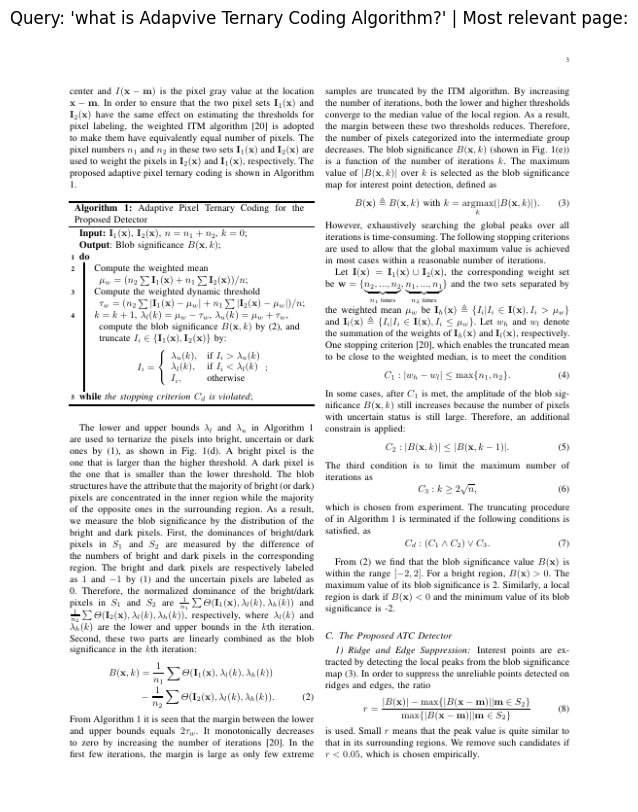

In [79]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread(output_path + "/" + str(top_page) + ".png")
plt.figure(figsize=(13, 10))
plt.imshow(img)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()


### Functionizing our semantic search pipeline

Let's put all of the steps from above for semantic search into a function or two so we can repeat the workflow. (just wrapping the above steps)

In [81]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

Excellent! Now let's test our functions out.

In [86]:
query = "what is the conclusion of the article"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 25 embeddings: 0.00008 seconds.


(tensor([0.1652, 0.1445, 0.1041, 0.0902, 0.0387]),
 tensor([10, 11, 20, 24, 16]))

In [87]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 25 embeddings: 0.00006 seconds.
Query: what is the conclusion of the article

Results:
Score: 0.1652
respectively, where Au(k) and An(k) are the lower and upper bounds in the kth
iteration. Second, these two parts are linearly combined as the blob
significance in the kth iteration: $$ \begin{aligned} {B ( \mathbf{x}, k )} &
{{}=\frac{1} {n_{1}} \sum\Theta( \mathbf{I}_{1} ( \mathbf{x} ), \lambda_{l} ( k
), \lambda_{h} ( k ) )} \\ {} & {{}-\frac{1} {n_{2}} \sum\Theta( \mathbf{I}_{2}
( \mathbf{x} ), \lambda_{l} ( k ), \lambda_{h} ( k ) ).. \qquad\quad( 2 )} \\
\end{aligned} $$ From Algorithm 1 it is seen that the margin between the lower
and upper bounds equals 2ry- It monotonically decreases to zero by increasing
the number of iterations [20]. In the first few iterations, the margin is large
as only few extreme samples are truncated by the ITM algorithm. By increasing
the number of iterations, both the lower and higher thresholds econverge to the
median

### Semantic search/vector search extensions

We've covered an exmaple of using embedding vector search to find relevant results based on a query.

However, you could also add to this pipeline with traditional keyword search.

Many modern search systems use keyword and vector search in tandem.

Our dataset is small and allows for an exhaustive search (comparing the query to *every* possible result) but if you start to work with large scale datasets with hundred of thousands, millions or even billions of vectors, you'll want to implement an index.

You can think of an index as sorting your embeddings before you search through them.

So it narrows down the search space.

For example, it would be inefficient to search every word in the dictionary to find the word "duck", instead you'd go straight to the letter D, perhaps even straight to the back half of the letter D, find words close to "duck" before finding it.

That's how an index can help search through many examples without comprimising too much on speed or quality (for more on this, check out [nearest neighbour search](https://en.wikipedia.org/wiki/Nearest_neighbor_search)).

One of the most popular indexing libraries is [Faiss](https://github.com/facebookresearch/faiss).

Faiss is open-source and was originally created by Facebook to deal with internet-scale vectors and implements many algorithms such as [HNSW](https://arxiv.org/abs/1603.09320) (Hierarchical Naviganle Small Worlds).

# 4. Use LLM to generate text based on the argumented info (TBD)

We're got our retrieval pipeline ready, let's now get the generation side of things happening.

To perform generation, we're going to use a Large Language Model (LLM).

LLMs are designed to generate an output given an input.

In our case, we want our LLM to generate and output of text given a input of text.

And more specifically, we want the output of text to be generated based on the context of relevant information to the query.

The input to an LLM is often referred to as a prompt.

We'll augment our prompt with a query as well as context from our textbook related to that query.

> **Which LLM should I use?**

There are many LLMs available.

Two of the main questions to ask from this is:
1. Do I want it to run locally?
2. If yes, how much compute power can I dedicate?

If you're after the absolute best performance, you'll likely want to use an API (not running locally) such as GPT-4 or Claude 3. However, this comes with the tradeoff of sending your data away and then awaiting a response.

For our case, since we want to set up a local pipeline and run it on our own GPU, we'd answer "yes" to the first question and then the second question will depend on what hardware we have available.

To find open-source LLMs, one great resource is the [Hugging Face open LLM leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard).

The leaderboard compares many of the latest and greatest LLMs on various benchmarks.

Another great resource is [TheBloke on Hugging Face](https://huggingface.co/TheBloke), an account which provides an extensive range of quantized (models that have been made smaller) LLMs.

A rule of thumb for LLMs (and deep learning models in general) is that the higher the number of parameters, the better the model performs.

It may be tempting to go for the largest size model (e.g. a 70B parameter model rather than a 7B parameter model) but a larger size model may not be able to run on your available hardware.

The following table gives an insight into how much GPU memory you'll need to load an LLM with different sizes and different levels of [numerical precision](https://en.wikipedia.org/wiki/Precision_(computer_science)).

They are based on the fact that 1 float32 value (e.g. `0.69420`) requires 4 bytes of memory and 1GB is approximately 1,000,000,000 (one billion) bytes.

| Model Size (Billion Parameters) | Float32 VRAM (GB) | Float16 VRAM (GB) | 8-bit VRAM (GB) | 4-bit VRAM (GB) |
|-----|-----|-----|-----|-----|
| 1B                              | ~4                | ~2                | ~1              | ~0.5            |
| 7B (e.g., [Llama 2 7B](https://huggingface.co/meta-llama/Llama-2-7b), [Gemma 7B](https://huggingface.co/google/gemma-7b-it), [Mistral 7B](https://huggingface.co/mistralai/Mistral-7B-v0.1))             | ~28               | ~14               | ~7              | ~3.5            |
| 10B                             | ~40               | ~20               | ~10             | ~5              |
| 70B (e.g, Llama 2 70B)          | ~280              | ~140              | ~70             | ~35             |
| 100B                            | ~400              | ~200              | ~100            | ~50             |
| 175B                            | ~700              | ~350              | ~175            | ~87.5           |

<br>

> **Note:** Loading a model in a lower precision (e.g. 8-bit instead of float16) generally lowers performance. Lower precision can help to reduce computing requirements, however sometimes the performance degradation in terms of model output can be substantial. Finding the right speed/performance tradeoff will often require many experiments.

### Checking local GPU memory availability

Let's find out what hardware we've got available and see what kind of model(s) we'll be able to load.

> **Note:** You can also check this with the `!nvidia-smi` command.

In [ ]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 24 GB


Ok wonderful!

I'm running this notebook with a NVIDIA RTX 4090, so I've got 24GB of VRAM available.

However, this may be different on your end.

Looking at the table above, it seems we can run a ~7-10B parameter model in float16 precision pretty comfortably.

But we could also run a smaller one if we'd like.

Let's try out the recently released (at the time of writing, March 2024) LLM from Google, [Gemma](https://huggingface.co/blog/gemma).

Specifically, we'll use the `gemma-7b-it` version which stands for Gemma 7B Instruction-Tuned.

Instruction tuning is the process of tuning a raw language model to follow instructions.

These are the kind of models you'll find in most chat-based assistants such as ChatGPT, Gemini or Claude.

The following table shows different amounts of GPU memory requirements for different verions of the Gemma LLMs with varying levels of precision.

| Model             | Precision | Min-Memory (Bytes) | Min-Memory (MB) | Min-Memory (GB) | Recommended Memory (GB) | Hugging Face ID |
|-------------------|-----------|----------------|-------------|-------------| ----- | ----- |
| [Gemma 2B](https://huggingface.co/google/gemma-2b-it)          | 4-bit     | 2,106,749,952  | 2009.15     | 1.96        | ~5.0 | [`gemma-2b`](https://huggingface.co/google/gemma-2b) or [`gemma-2b-it`](https://huggingface.co/google/gemma-2b-it) for instruction tuned version |
| Gemma 2B          | Float16   | 5,079,453,696  | 4844.14     | 4.73        | ~8.0 | Same as above |
| [Gemma 7B](https://huggingface.co/google/gemma-7b-it)          | 4-bit     | 5,515,859,968  | 5260.33     | 5.14        | ~8.0 | [`gemma-7b`](https://huggingface.co/google/gemma-7b) or [`gemma-7b-it`](https://huggingface.co/google/gemma-7b-it) for instruction tuned version |
| Gemma 7B          | Float16   | 17,142,470,656 | 16348.33    | 15.97       | ~19 | Same as above |

> **Note:** `gemma-7b-it` means "instruction tuned", as in, a base LLM (`gemma-7b`) has been fine-tuned to follow instructions, similar to [`Mistral-7B-v0.1`](https://huggingface.co/mistralai/Mistral-7B-v0.1) and [`Mistral-7B-Instruct-v0.1`](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1).
>
> There are also further quantized and smaller variants of Gemma (and other LLMs) available in various formats such as GGUF. You can see many of these on [TheBloke account on Hugging Face](https://huggingface.co/TheBloke).
>
> The version of LLM you choose to use will be largely based on project requirements and experimentation.

Based on the table above, let's write a simple if/else statement which recommends which Gemma variant we should look into using.

In [ ]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 24 | Recommend model: Gemma 7B in 4-bit or float16 precision.
use_quantization_config set to: False
model_id set to: google/gemma-7b-it


### Loading an LLM locally

Alright! Looks like `gemma-7b-it` it is (for my local machine with an RTX 4090, change the `model_id` and `use_quantization_config` values to suit your needs)!

There are plenty of examples of how to load the model on the `gemma-7b-it` [Hugging Face model card](https://huggingface.co/google/gemma-7b-it).

Good news is, the Hugging Face [`transformers`](https://huggingface.co/docs/transformers/) library has all the tools we need.

To load our LLM, we're going to need a few things:
1. A quantization config (optional) - This will determine whether or not we load the model in 4bit precision for lower memory usage. The we can create this with the [`transformers.BitsAndBytesConfig`](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/quantization#transformers.BitsAndBytesConfig) class (requires installing the [`bitsandbytes` library](https://github.com/TimDettmers/bitsandbytes)).
2. A model ID - This is the reference Hugging Face model ID which will determine which tokenizer and model gets used. For example `gemma-7b-it`.
3. A tokenzier - This is what will turn our raw text into tokens ready for the model. We can create it using the [`transformers.AutoTokenzier.from_pretrained`](https://huggingface.co/docs/transformers/v4.38.2/en/model_doc/auto#transformers.AutoTokenizer) method and passing it our model ID.
4. An LLM model - Again, using our model ID we can load a specific LLM model. To do so we can use the [`transformers.AutoModelForCausalLM.from_pretrained`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForCausalLM.from_pretrained) method and passing it our model ID as well as other various parameters.

As a bonus, we'll check if [Flash Attention 2](https://huggingface.co/docs/transformers/perf_infer_gpu_one#flashattention-2) is available using `transformers.utils.is_flash_attn_2_available()`. Flash Attention 2 speeds up the attention mechanism in Transformer architecture models (which is what many modern LLMs are based on, including Gemma). So if it's available and the model is supported (not all models support Flash Attention 2), we'll use it. If it's not available, you can install it by following the instructions on the [GitHub repo](https://github.com/Dao-AILab/flash-attention).

> **Note:** Flash Attention 2 currently works on NVIDIA GPUs with a compute capability score of 8.0+ (Ampere, Ada Lovelace, Hopper architectures). We can check our GPU compute capability score with [`torch.cuda.get_device_capability(0)`](https://pytorch.org/docs/stable/generated/torch.cuda.get_device_capability.html).

> **Note:** To get access to the Gemma models, you will have to [agree to the terms & conditions](https://huggingface.co/google/gemma-7b-it) on the Gemma model page on Hugging Face. You will then have to authorize your local machine via the [Hugging Face CLI/Hugging Face Hub `login()` function](https://huggingface.co/docs/huggingface_hub/en/quick-start#authentication). Once you've done this, you'll be able to download the models. If you're using Google Colab, you can add a [Hugging Face token](https://huggingface.co/docs/hub/en/security-tokens) to the "Secrets" tab.
>
> Downloading an LLM locally can take a fair bit of time depending on your internet connection. Gemma 7B is about a 16GB download and Gemma 2B is about a 6GB download.

Let's do it!

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using attention implementation: flash_attention_2
[INFO] Using model_id: google/gemma-7b-it


You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

We've got an LLM!

Let's check it out.

In [ ]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaFlashAttention2(
          (q_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (v_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3072, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (up_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (down_proj): Linear(in_features=24576, out_features=3072, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): Gem

Ok, ok a bunch of layers ranging from embedding layers to attention layers (see the `GemmaFlashAttention2` layers!) to MLP and normalization layers.

The good news is that we don't have to know too much about these to use the model.

How about we get the number of parameters in our model?

In [ ]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

8537680896

Hmm, turns out that Gemma 7B is really Gemma 8.5B.

It pays to do your own investigations!

How about we get the models memory requirements?

In [ ]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 17142470656,
 'model_mem_mb': 16348.33,
 'model_mem_gb': 15.97}

Nice, looks like this model takes up 15.97GB of space on the GPU.

Plus a little more for the forward pass (due to all the calculations happening between the layers).

Hence why I rounded it up to be ~19GB in the table above.

Now let's get to the fun part, generating some text!

### Generating text with our LLM

We can generate text with our LLM `model` instance by calling the [`generate()` method](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig) (this method has plenty of options to pass into it alongside the text) on it and passing it a tokenized input.

The tokenized input comes from passing a string of text to our `tokenizer`.

It's important to note that you should use a tokenizer that has been paired with a model.

Otherwise if you try to use a different tokenizer and then pass those inputs to a model, you will likely get errors/strange results.

For some LLMs, there's a specific template you should pass to them for ideal outputs.

For example, the `gemma-7b-it` model has been trained in a dialogue fashion (instruction tuning).

In this case, our `tokenizer` has a [`apply_chat_template()` method](https://huggingface.co/docs/transformers/main/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.apply_chat_template) which can prepare our input text in the right format for the model.

Let's try it out.

> **Note:** The following demo has been modified from the Hugging Face model card for [Gemma 7B](https://huggingface.co/google/gemma-7b-it). Many similar demos of usage are available on the model cards of similar models.

In [ ]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



Notice the scaffolding around our input text, this is the kind of turn-by-turn instruction tuning our model has gone through.

Our next step is to tokenize this formatted text and pass it to our model's `generate()` method.

We'll make sure our tokenized text is on the same device as our model (GPU) using `to("cuda")`.

Let's generate some text!

We'll time it for fun with the `%%time` magic.

In [ ]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
            573,   3515,   2971, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
           573,   3515,   2971, 235336,    107,    108,    106,   2516,    108,
         21404, 235269,   1517,    708,    573, 186809, 184592,    578,   1024,
         16065,    575,    573,   3515,   2971, 235292,    109,    688,  12298,
          1695, 184592,  66058,    109,    688, 235274, 235265, 110165,  56227,
         66058,    109, 235290,   5231,  11071,  6

Woohoo! We just generated some text on our local GPU!

Well not just yet...

Our LLM accepts tokens in and sends tokens back out.

We can conver the output tokens to text using [`tokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode).

In [ ]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
Sure, here are the macronutrients and their roles in the human body:

**Macronutrients:**

**1. Carbohydrates:**

- **Role:**
  - Provide energy for the body.
  - Help regulate blood sugar levels.
  - Provide fiber for digestion and gut health.

**2. Proteins:**

- **Role:**
  - Build and repair tissues.
  - Create enzymes and other chemicals.
  - Help regulate blood sugar levels.

**3. Fats:**

- **Role:**
  - Provide energy storage.
  - Help absorb vitamins and minerals.
  - Help regulate blood sugar levels.

**Other Functions:**

- Macronutrients play a role in regulating the body's metabolism, which is the process of breaking down food into energy.
- They also help to build and repair tissues, and to produce energy for the body.
- Macronutrients are essential for overall health and well-being.<eos>



Woah! That looks like a pretty good answer.

But notice how the output contains the prompt text as well?

How about we do a little formatting to replace the prompt in the output text?

> **Note:** `"<bos>"` and `"<eos>"` are special tokens to denote "beginning of sentence" and "end of sentence" respectively.

In [ ]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What are the macronutrients, and what roles do they play in the human body?

Output text:
Sure, here are the macronutrients and their roles in the human body:

**Macronutrients:**

**1. Carbohydrates:**

- **Role:**
  - Provide energy for the body.
  - Help regulate blood sugar levels.
  - Provide fiber for digestion and gut health.

**2. Proteins:**

- **Role:**
  - Build and repair tissues.
  - Create enzymes and other chemicals.
  - Help regulate blood sugar levels.

**3. Fats:**

- **Role:**
  - Provide energy storage.
  - Help absorb vitamins and minerals.
  - Help regulate blood sugar levels.

**Other Functions:**

- Macronutrients play a role in regulating the body's metabolism, which is the process of breaking down food into energy.
- They also help to build and repair tissues, and to produce energy for the body.
- Macronutrients are essential for overall health and well-being.


How cool is that!

We just officially generated text from an LLM running locally.

So we've covered the R (retrieval) and G (generation) of RAG.

How about we check out the last step?

Augmentation.

First, let's put together a list of queries we can try out with our pipeline.

In [ ]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

And now let's check if our `retrieve_relevant_resources()` function works with our list of queries.

In [ ]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: How do vitamins and minerals differ in their roles and importance for health?
[INFO] Time taken to get scores on 1680 embeddings: 0.00004 seconds.


(tensor([0.6322, 0.6220, 0.6187, 0.6178, 0.6128], device='cuda:0'),
 tensor([ 51,  47, 874,  41, 927], device='cuda:0'))

Beautiful!

Let's augment!

### Augmenting our prompt with context items

What we'd like to do with augmentation is take the results from our search for relevant resources and put them into the prompt that we pass to our LLM.

In essence, we start with a base prompt and update it with context text.

Let's write a function called `prompt_formatter` that takes in a query and our list of context items (in our case it'll be select indices from our list of dictionaries inside `pages_and_chunks`) and then formats the query with text from the context items.

We'll apply the dialogue and chat template to our prompt before returning it as well.

> **Note:** The process of augmenting or changing a prompt to an LLM is known as prompt engineering. And the best way to do it is an active area of research. For a comprehensive guide on different prompt engineering techniques, I'd recommend the Prompt Engineering Guide ([promptingguide.ai](https://www.promptingguide.ai/)), [Brex's Prompt Engineering Guide](https://github.com/brexhq/prompt-engineering) and the paper [Prompt Design and Engineering: Introduction and Advanced Models](https://arxiv.org/abs/2401.14423).

In [ ]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

Looking good! Let's try our function out.

In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: How often should infants be breastfed?
[INFO] Time taken to get scores on 1680 embeddings: 0.00003 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and

What a good looking prompt!

We can tokenize this and pass it straight to our LLM.

In [ ]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: How often should infants be breastfed?
RAG answer:
<bos>**Relevant passages:**

"A newborn infant (birth to 28 days) requires feedings eight to twelve times a day or more. Between 1 and 3 months of age, the breastfed infant becomes more efficient, and the number of feedings per day often become fewer even though the amount of milk consumed stays the same. After about six months, infants can gradually begin to consume solid foods to help meet nutrient needs."

"The US Department of Agriculture’s Women, Infants, and Children program provides information on breastfeeding and both professional and peer support for women and their babies from low-income families."

**Answer:**

Infants should be breastfed eight to twelve times a day or more when they are newborns and as often as they need when they are between 1 and 3 months old. After about six months, infants can gradually begin to consume solid foods to help meet nutrient needs.<eos>
CPU times: total: 266 ms
Wall time: 6.11 s


Yesssssss!!!

Our RAG pipeline is complete!

We just Retrieved, Augmented and Generated!

And all on our own local GPU!

How about we functionize the generation step to make it easier to use?

We can put a little formatting on the text being returned to make it look nice too.

And we'll make an option to return the context items if needed as well.

In [ ]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

What a good looking function!

The workflow could probably be a little refined but this should work!

Let's try it out.

In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: What are the macronutrients, and what roles do they play in the human body?
[INFO] Time taken to get scores on 1680 embeddings: 0.00003 seconds.
Answer:

Sure, here is the answer to the query:  Macronutrients are the nutrients that
are needed in large amounts by the human body. There are three classes of
macronutrients: carbohydrates, lipids, and proteins. These macronutrients can be
metabolically processed into cellular energy.  Carbohydrates are molecules
composed of carbon, hydrogen, and oxygen. Proteins are macromolecules composed
of chains of subunits called amino acids. Lipids are molecules that are composed
of fatty acids and glycerol. Water is also a macronutrient in the sense that you
require a large amount of it, but unlike the other macronutrients, it does not
yield calories.
Context items:


[{'page_number': 5,
  'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of c

Local RAG workflow complete!

We've now officially got a way to Retrieve, Augment and Generate answers based on a source.

For now we can verify our answers manually by reading them and reading through the textbook.

But if you want to put this into a production system, it'd be a good idea to have some kind of evaluation on how well our pipeline works.

For example, you could use another LLM to rate the answers returned by our LLM and then use those ratings as a proxy evaluation.

However, I'll leave this and a few more interesting ideas as extensions.

## Extensions

* May want to improve text extraction with something like Marker - https://github.com/VikParuchuri/marker
* Guide to more advanced PDF extraction - https://towardsdatascience.com/extracting-text-from-pdf-files-with-python-a-comprehensive-guide-9fc4003d517
* See the following prompt engineering resources for more prompting techniques - promptinguide.ai, Brex's Prompt Engineering Guide
* What happens when a query comes through that there isn't any context in the textbook on?
* Try another embedding model (e.g. Mixed Bread AI large, `mixedbread-ai/mxbai-embed-large-v1`, see: https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)
* Try another LLM... (e.g. Mistral-Instruct)
* Try different prompts (e.g. see prompting techniques online)
* Our example only focuses on text from a PDF, however, we could extend it to include figures and images
* Evaluate the answers -> could use another LLM to rate our answers (e.g. use GPT-4 to make)
* Vector database/index for larger setup (e.g. 100,000+ chunks)
* Libraries/frameworks such as LangChain / LlamaIndex can help do many of the steps for you - so it's worth looking into those next, wanted to recreate a workflow with lower-level tools to show the principles
* Optimizations for speed
    * See Hugging Face docs for recommended speed ups on GPU - https://huggingface.co/docs/transformers/perf_infer_gpu_one
    * Optimum NVIDIA - https://huggingface.co/blog/optimum-nvidia, GitHub: https://github.com/huggingface/optimum-nvidia
    * See NVIDIA TensorRT-LLM - https://github.com/NVIDIA/TensorRT-LLM
    * See GPT-Fast for PyTorch-based optimizations - https://github.com/pytorch-labs/gpt-fast
    * Flash attention 2 (requires Ampere GPUs or newer) - https://github.com/Dao-AILab/flash-attention
* Stream text output so it looks prettier (e.g. each token appears as it gets output from the model)
* Turn the workflow into an app, see Gradio type chatbots for this - https://www.gradio.app/guides/creating-a-chatbot-fast, see local example: https://www.gradio.app/guides/creating-a-chatbot-fast#example-using-a-local-open-source-llm-with-hugging-face